# <center> Convolutional Networks </center>

In [1]:
import numpy             as np
import scipy             as sc
import sklearn           as sk
import pandas            as pd
import matplotlib.pyplot as plt
import tensorboard       as tb
import tensorflow        as tf
import pickle

%load_ext tensorboard


from scipy.ndimage           import shift
from scipy.ndimage           import rotate
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils  import to_categorical


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input, Dropout
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, ReLU, BatchNormalization

In [ ]:
mnist = pd.read_csv("./mnist_train_small.csv", header=None, sep=";").values

X, Y = mnist[:, 1:], mnist[:, 0:1]

Xt = X / 255.0
Yt = to_categorical(Y, 10)


X_train, X_test, Y_train, Y_test = train_test_split(Xt, Yt, train_size=0.7)

In [ ]:
def traslate_imgs(X):

    trasl_X = np.zeros(X.shape)

    for ix, x in enumerate(X):
        
        rx = x.reshape(28, 28)
        
        shift_x = np.random.randint(14) - 7
        shift_y = np.random.randint(14) - 7
        trasl_X[ix] = shift(x.reshape(28, 28), (shift_x, shift_y)).flatten()

    return trasl_X

In [ ]:
def rotate_imgs(X):

    rot_X = np.zeros(X.shape)

    for ix, x in enumerate(X):
    
        rx = x.reshape(28, 28)
        angle = np.random.randint(180) - 90
        rot_X[ix] = rotate(x.reshape(28, 28), angle, reshape=False, prefilter=False, order=1).flatten()
    
    return rot_X

In [ ]:
def noise_imgs(X, noise_level=0.5):

    nois_X = np.zeros(X.shape)

    for ix, x in enumerate(X):
    
        rx = x.reshape(28, 28)
    
        noise = (np.random.random(x.shape) * 2.0  - 1) * noise_level
        nois_X[ix] = np.clip(x + noise, 0.0, 1.0).flatten()

    return nois_X

In [ ]:
def augmentDataset(X, Y):
    
    trasX = traslate_imgs(X)
    rotaX = rotate_imgs(X)
    
    no50X = noise_imgs(X, 0.5)
    no25X = noise_imgs(X, 0.25)

    augmX = np.vstack([X, 
                    trasX, 
                    rotaX, 
                    no50X, 
                    no25X])

    augmY = np.tile(Y, (5,1))

    return augmX, augmY

In [ ]:
augmX_train, augmY_train = augmentDataset(X_train, Y_train)
augmX_test,  augmY_test  = augmentDataset(X_test, Y_test)

print(X_train.shape, augmX_train.shape)
print(X_test.shape,  augmX_test.shape)

In [ ]:
# Visualizamos los datos generados.
idx = 100

fig, axs = plt.subplots(1,5,figsize=(12,12))

axs[0].matshow(augmX_train[idx + len(X_train) * 0,:].reshape(28, 28))
axs[1].matshow(augmX_train[idx + len(X_train) * 1,:].reshape(28, 28))
axs[2].matshow(augmX_train[idx + len(X_train) * 2,:].reshape(28, 28))
axs[3].matshow(augmX_train[idx + len(X_train) * 3,:].reshape(28, 28))
axs[4].matshow(augmX_train[idx + len(X_train) * 4,:].reshape(28, 28))

plt.show()

In [ ]:
model = Sequential()


model.add(Conv2D(kernel_size=5, strides=1, filters=8, padding='same', name='layer_conv1'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(pool_size=2, strides=2))


model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same', name='layer_conv2'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(pool_size=2, strides=2))


model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same', name='layer_conv3'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(pool_size=2, strides=2))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.05),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
logdir="logs/MNIST-Convolutional-DataAugmentation"

tf.profiler.experimental.start(logdir=logdir)

model.fit(x=augmX_train.reshape(augmX_train.shape[0], 28, 28, 1), 
          y=augmY_train,
          validation_data=(augmX_test.reshape(augmX_test.shape[0], 28, 28, 1), augmY_test),
          epochs=20,
          batch_size=64)

tf.profiler.experimental.stop()

In [ ]:
model.summary()

In [18]:
# localhost:6006

%tensorboard --logdir="logs" --port=6007

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 1768.

## CIFAR100 - Dataset

---


In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
train = unpickle("./cifar-100-python/train")
test  = unpickle("./cifar-100-python/test")

In [4]:
x_train = train[b'data'].reshape(50000, 3, 32, 32).transpose(0, 2, 3, 1)
y_train = to_categorical(train[b'coarse_labels'], 100)

x_test  = test[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)
y_test  = to_categorical(test[b'coarse_labels'], 100)

In [5]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)


datagen_train.fit(x_train)
datagen_test.fit(x_test)


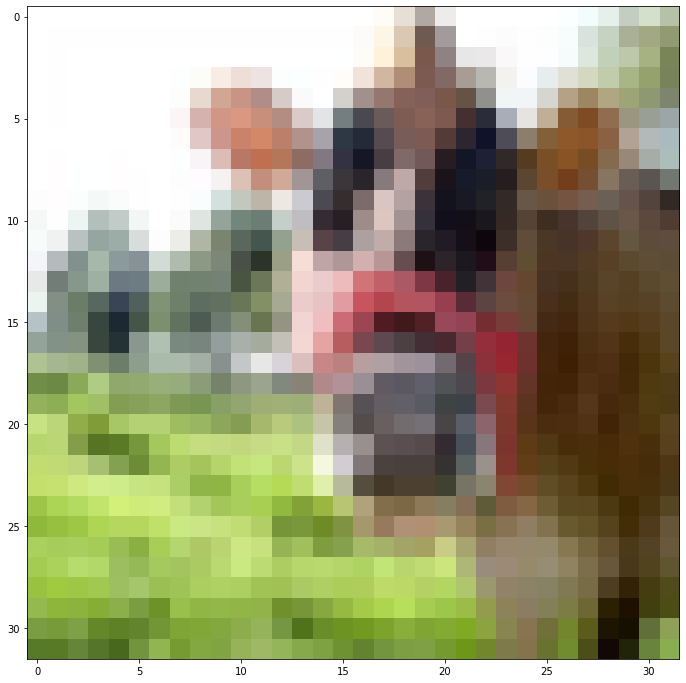

In [6]:
fig, axs = plt.subplots(1,1,figsize=(12,12))
axs.imshow(x_train[0])
plt.show()

In [7]:
model = Sequential()


model.add(Conv2D(kernel_size=3, strides=1, filters=8, padding='same', name='layer_conv1'))

model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(pool_size=2, strides=1))


model.add(Conv2D(kernel_size=3, strides=1, filters=16, name='layer_conv2'))

model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(pool_size=2, strides=1))


model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same', name='layer_conv3'))

model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(pool_size=2, strides=1))


model.add(Conv2D(kernel_size=5, strides=1, filters=64, name='layer_conv4'))


model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(pool_size=2, strides=1))

model.add(Conv2D(kernel_size=5, strides=1, filters=128, padding='same', name='layer_conv5'))

model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(pool_size=2, strides=1))




model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(100, activation='softmax'))

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [21]:

# logdir="logs/cifar-100-Convolutional-DataAugmentation"

logdir="logs/fit-cifar-100-Convolutional/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


# tf.profiler.experimental.start(logdir=logdir)

model.fit(datagen_train.flow(x_train, y_train, batch_size=64),
          steps_per_epoch=len(x_train) / 64,
          validation_data=datagen_test.flow(x_test, y_test, batch_size=64),
          epochs=50,
          batch_size=64, 
          callbacks=[tensorboard_callback])

# tf.profiler.experimental.stop()

Epoch 1/50
782/781 [==============================] - 41s 53ms/step - loss: 0.9632 - acc: 0.6936 - val_loss: 1.3549 - val_acc: 0.5994
Epoch 2/50
782/781 [==============================] - 41s 52ms/step - loss: 0.9564 - acc: 0.6973 - val_loss: 1.3076 - val_acc: 0.6110
Epoch 3/50
782/781 [==============================] - 39s 50ms/step - loss: 0.9486 - acc: 0.6999 - val_loss: 1.2413 - val_acc: 0.6283
Epoch 4/50
782/781 [==============================] - 40s 51ms/step - loss: 0.9390 - acc: 0.7015 - val_loss: 1.3317 - val_acc: 0.6036
Epoch 5/50
782/781 [==============================] - 37s 47ms/step - loss: 0.9442 - acc: 0.6985 - val_loss: 1.2783 - val_acc: 0.6163
Epoch 6/50
782/781 [==============================] - 38s 48ms/step - loss: 0.9425 - acc: 0.6978 - val_loss: 1.3132 - val_acc: 0.6127
Epoch 7/50
782/781 [==============================] - 39s 50ms/step - loss: 0.9426 - acc: 0.7010 - val_loss: 1.4167 - val_acc: 0.5845
Epoch 8/50
782/781 [==============================] - 37s 47ms

In [22]:
model.save('./models-saves/cifar-100-71-62') 

INFO:tensorflow:Assets written to: ./models-saves/cifar-100-71-62\assets


In [15]:
tf.summary.File()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, None, None, 8)     224       
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 8)     32        
_________________________________________________________________
re_lu (ReLU)                 (None, None, None, 8)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 8)     0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, None, None, 16)    1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 16)    64        
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, None, 16)    0